# MediaSearch Interleaved A/B Test Analysis

The Structured Data team ran an interleaved A/B test of search on Commons, and we're wanting to understand if there was a difference in preference between the two options. This analysis builds on [Estimating Preference for Ranking Functions with Clicks on Interleaved Search Results](https://people.wikimedia.org/~bearloga/notes/interleaved.html) by Mikhail Popov, and the majority of this notebook is also written by him.

The phabricator task for this analysis is [T261759](https://phabricator.wikimedia.org/T261759)

The test started on 2020-09-10, and ended on 2020-09-17. The timestamps are roughly accurate to within a minute and are gathered from the [Server Admin Log](https://wikitech.wikimedia.org/wiki/Server_Admin_Log).

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
# install.packages(c("tidyverse", "remotes", "furrr"))
library(tidyverse)
library(lubridate)
library(future)
plan(multiprocess(workers = getOption("mc.cores", 2)))
library(furrr) # future-enabled purrr

library(wmfdata) # remotes::install_github("wikimedia/wmfdata-r")
library(wmfastr) # remotes::install_github("wikimedia/wmfastr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
# Name of the test configuration:
subtest_name = 'mediasearch_commons_int'

# Start and end timestamps (approximate is fine, as we also filter on subtest):
start_ts = ymd_hms('2020-09-10T11:00:00Z')
end_ts = ymd_hms('2020-09-17T12:00:00Z')

In [4]:
data_query = paste0("USE event;
SELECT
  coalesce(client_dt, meta.dt) AS event_ts,
  event.uniqueId AS event_id,
  event.mwSessionId AS mw_session_id,
  event.pageViewId AS page_id,
  event.articleId AS article_id,
  event.searchSessionId AS session_id,
  event.subTest AS group,
  wiki,
  event.source AS search_type, -- fulltext or autocomplete
  event.searchtoken AS search_token, -- uniquely links visitPage events to specific SRP events
  MD5(LOWER(TRIM(event.query))) AS query_hash,
  event.action AS event,
  IF(event.position < 0, NULL, event.position) AS event_position,
  CASE
    WHEN event.action = 'searchResultPage' AND event.hitsReturned > -1 THEN event.hitsReturned
    WHEN event.action = 'searchResultPage' AND event.hitsReturned IS NULL THEN 0
    ELSE NULL END AS n_results,
  event.extraParams AS event_extraparams
FROM searchsatisfaction
WHERE year = 2020
  AND month = 9
  AND day BETWEEN 10 AND 17
  AND event.subtest = '", subtest_name, "'
  AND coalesce(client_dt, meta.dt) IS NOT NULL
  AND coalesce(client_dt, meta.dt) > '", format_ISO8601(start_ts), "'
  AND coalesce(client_dt, meta.dt) < '", format_ISO8601(end_ts), "'
  AND wiki = 'commonswiki'
  AND event.action IN ('searchResultPage', 'visitPage')
  AND CASE
    WHEN event.action = 'searchResultPage' THEN event.msToDisplayResults IS NOT NULL
    WHEN event.action = 'visitPage' THEN event.pageViewId IS NOT NULL
    ELSE TRUE END
  AND useragent.is_bot = false;"
)

In [5]:
if (!fs::file_exists("events.rds")) {
    # De-duplicated dataset does not exist yet
    if (fs::file_exists("events_backup.rds")) {
        events <- readr::read_rds("events_backup.rds") # load cached
    } else {
        events = query_hive(data_query)
        readr::write_rds(events, "events_backup.rds", compress = "gz") # cache
    }
    print(c(Events = nrow(events), Sessions = length(unique(events$session_id))))
} else {
    # De-duplicated dataset exists, do nothing
}

NULL

In [6]:
if (fs::file_exists("events.rds")) {
    events <- readr::read_rds("events.rds") # load cached
} else {
    # De-duplicate events:
    events <- events %>%
      dplyr::mutate(
        timestamp = lubridate::ymd_hms(event_ts),
        date = as.Date(timestamp)
      ) %>%
      dplyr::arrange(session_id, event_id, timestamp) %>%
      dplyr::distinct(session_id, event_id, .keep_all = TRUE)
    readr::write_rds(events, "events.rds", compress = "gz") # cache
}
print(c(Events = nrow(events), Sessions = length(unique(events$session_id))))

  Events Sessions 
  660962    59250 


`process_session()` takes an input of events belonging to a session, matches the visited pages with the team drafts in the search result page events, and outputs the memberships. It limits visited pages to those with a position of less than 20, as there is no interleaving on pages beyond the first one, and the highest combined number of interleaved results we've seen is 20.

In [7]:
process_session <- function(events_subset) {
  serp_events <- events_subset %>%
    filter(event == "searchResultPage", event_extraparams != "NULL", n_results > 0) %>%
    # Extract team drafts from the extraParams JSON:
    mutate(team_drafts = map(event_extraparams, ~ jsonlite::fromJSON(.x)$teamDraft)) %>%
    select(page_id, search_token, n_results, team_drafts) %>%
    # Remove SERP events missing team draft info:
    filter(!map_lgl(team_drafts, is.null))
  visit_page_events <- events_subset %>%
    filter(event == "visitPage", event_position < 20) %>%
    select(search_token, article_id)
  visited_teams <- visit_page_events %>%
    left_join(serp_events, by = "search_token") %>%
    mutate(team = map2_chr(article_id, team_drafts, function(id, teams) {
      dplyr::case_when(
        id %in% teams$a ~ "A",
        id %in% teams$b ~ "B",
        TRUE ~ as.character(NA)
      )
    })) %>%
    select(team)
  return(visited_teams)
}

In [15]:
events <- split(events, events$session_id)
visited <- future_map_dfr(events, process_session, .id = "session_id", .progress = FALSE)
write_rds(visited, "visited.rds", compress = "gz")

In [16]:
table(visited$team) # counts of visited pages from the two teams


    A     B 
14251 13591 

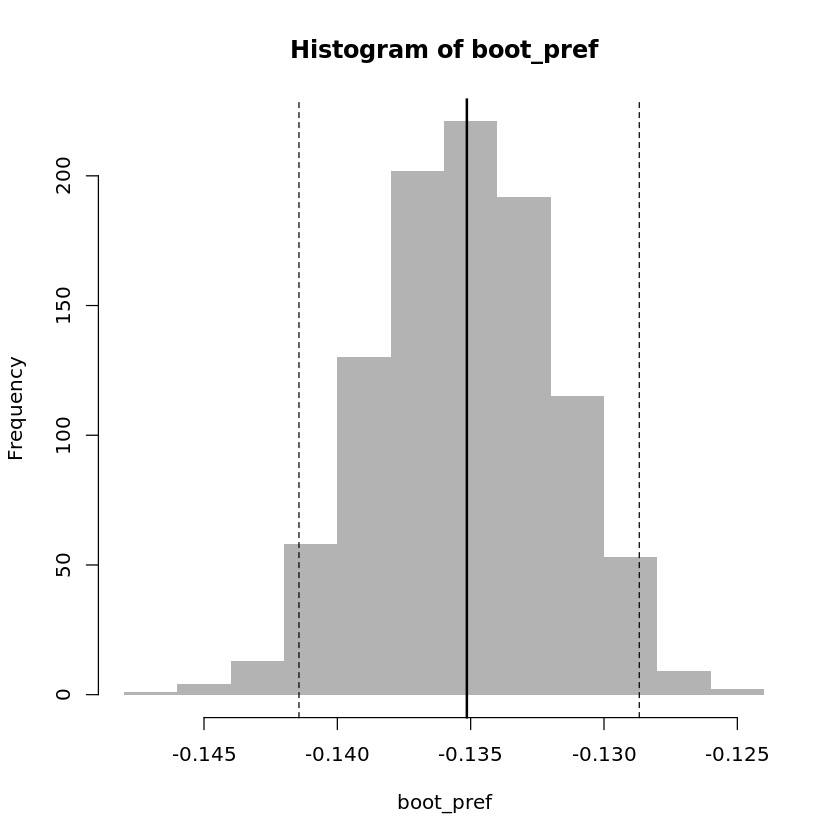

In [10]:
boot_pref <- interleaved_bootstraps(visited$session_id, visited$team)
preference <- interleaved_preference(visited$session_id, visited$team)
hist(boot_pref, col = "gray70", border = NA)
abline(v = quantile(boot_pref, c(0.025, 0.975)), lty = "dashed")
abline(v = preference, lwd = 2)

In [11]:
preference

[1] -0.1351428

In [12]:
quantile(boot_pref, c(0.025, 0.975))

2.5%      97.5% 
-0.1414386 -0.1286775

## Sessions with less than 20/50 searches

In previous analysis of searches, there's been a threshold on the number of searches per session. This is because a high number of searches suggests a non-human user, and we're interested in understanding the behaviour of humans. We therefore check what the results are if we limit the number of searches per session.

In [17]:
session_lengths <- future_map_int(events, function(x) { nrow(x[x$event == 'searchResultPage', ]) })

In [18]:
session_lengths <- enframe(session_lengths, name = 'session_id', value = 'num_searches')

In [19]:
non_excessive_sessions <- session_lengths %>% filter(num_searches < 20)

In [20]:
non_excessive_visited <- visited %>% filter(session_id %in% non_excessive_sessions$session_id)

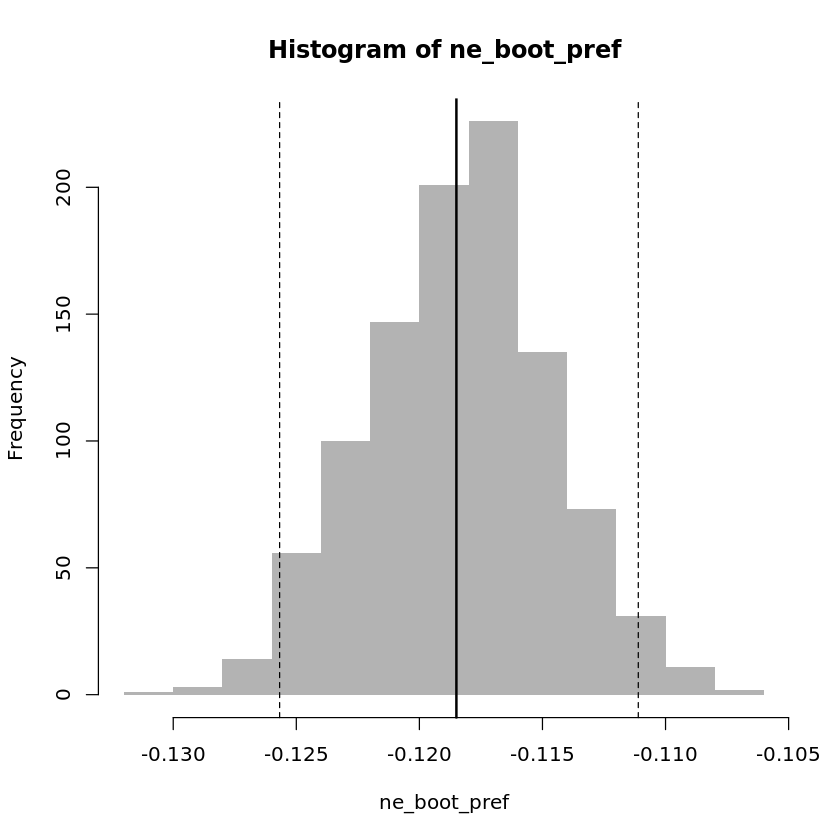

In [21]:
ne_boot_pref <- interleaved_bootstraps(non_excessive_visited$session_id, non_excessive_visited$team)
ne_preference <- interleaved_preference(non_excessive_visited$session_id, non_excessive_visited$team)
hist(ne_boot_pref, col = "gray70", border = NA)
abline(v = quantile(ne_boot_pref, c(0.025, 0.975)), lty = "dashed")
abline(v = ne_preference, lwd = 2)

In [22]:
ne_preference

[1] -0.1184964

I've run this with both 50 and 20 searches as the threshold, and the conclusion doesn't change: it's always an overwhelming majority towards Media Search.

## Conclusions

We've done this analysis counting only `visitPage` events with a position below 20, as the notebook currently does, and without that limitation. We've also checked whether a threshold for number of searches per session affects the findings, and found that neither 50 nor 20 has a significant effect. In all cases, we find a strong preference towards the new Media Search algorithm.